# 4. Modelling

In [1]:
import numpy as np

import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb

C:\Users\sumit\Anaconda3\envs\sdcnd\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv('../data/master_dataset.csv')

#index=0
#feature_dictionary={}
#for x in train_df.columns:
#    if (x=='BuildingID' or x=='Blighted'):
#        feature_dictionary[x]=x
#    else:
#        feature_dictionary[x]='ColIndex' + str(index)
#        index += 1
#train_df.rename(columns=feature_dictionary, inplace=True)

train_df.head(2)

,BuildingID,Blighted,CleanJudgmentAmt,#ViolationCategory0,#ViolationCategory1,#NO PAYMENT APPLIED,#NO PAYMENT ON RECORD,#PAID IN FULL,#PARTIAL PAYMENT MADE,#Violation,#Acknowledged,#Open,#Archived,#Closed,#Traffic Signal Issue,#Street Light Pole Down,#Running Water in a Home or Building,#Abandoned Vehicle,#Trash Issue - Bulk waste deposited more than 24 hours before designated time,#Illegal Dumping / Illegal Dump Sites,"#Customer Service (internal use only, private issue)",#Curbside Solid Waste Issue,#Potholes,#DPW - Debris Removal,#Clogged Drain,#Water Main Break,#Graffiti,"#Test (internal use only, public issue)",#Tree Issue,"#Graffiti Abatement (internal use only, public issue)",#Trash Issue - Improper placement of refuse container between collections/left at curbside,#Fire Hydrant Issue,#DPW - Other environmental,#Detroit Land Bank Referral,#Manhole Cover Issue,#Residential Snow Removal Issue,#Traffic Sign Issue,MeanCallRating,#Calls,#EMBEZZLEMENT,#CONSPIRACY BY COMPUTER,#OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE,#GAMBLING,#FELONY DEATH FROM FLEEING VEHICLE,#DRUNKENNESS,#OBSTRUCTING JUDICIARY,#IMMIGRATION,#OUIL,#JUSTIFIABLE HOMICIDE,#FAMILY OFFENSE,#HOMICIDE,#NEGLIGENT HOMICIDE,#OBSTRUCTING THE POLICE,#ELECTION LAWS,#PUBLIC PEACE,#ASSAULT,#SOLICITATION,#VAGRANCY (OTHER),#REVOKED,#KIDNAPING,#AGGRAVATED ASSAULT,#EXTORTION,#TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS,#OBSCENITY,#TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED,#WEAPONS OFFENSES,#ANTITRUST,#DANGEROUS DRUGS,#LARCENY,#ROBBERY,#RUNAWAY,#DAMAGE TO PROPERTY,#BRIBERY,#LIQUOR,#STOLEN PROPERTY,#ESCAPE,#ENVIRONMENT,#FORGERY,#HEALTH-SAFETY,#TAX REVENUE,#BURGLARY,#MISCELLANEOUS ARREST,#CONGRESS,#OTHER BURGLARY,#MILITARY,#ARSON,#SOVEREIGNTY,#STOLEN VEHICLE,#FRAUD,#Crimes
0,dpt10mx,1,11405.0,30.0,0.0,24.0,0.0,5.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dpscpjv,1,11105.0,31.0,0.0,31.0,0.0,0.0,0.0,31.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


In [3]:
X_master = train_df.drop(['BuildingID', 'Blighted'], axis=1)
y_master = train_df['Blighted']

X_train, X_val, y_train, y_val = train_test_split(X_master, y_master, test_size=0.3, stratify = y_master)

## Random Forest

In [4]:
clf = RandomForestClassifier(n_estimators=500)

In [5]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

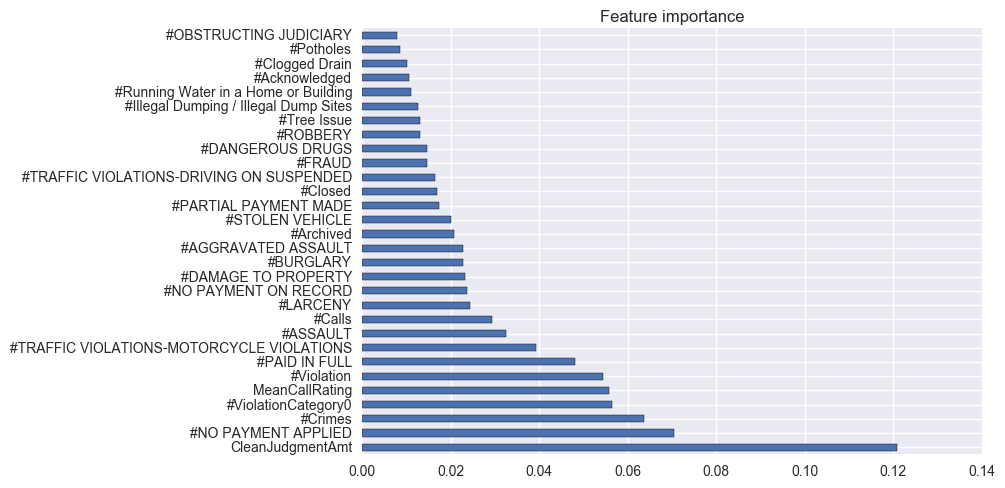

In [6]:
feature_importance = pd.Series(clf.feature_importances_, index=X_master.columns)
feature_importance.sort_values(inplace=True, ascending=False)
feature_importance.head(30).plot(kind='barh', title='Feature importance')

In [7]:
sum(clf.predict(X_val) == y_val) / float(len(y_val))

0.80662782228696284

In [8]:
sum(clf.predict(X_train) == y_train) / float(len(y_train))

0.99625409708131729

In [9]:
pred_probs = clf.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, pred_probs), 5)

0.68115000000000003

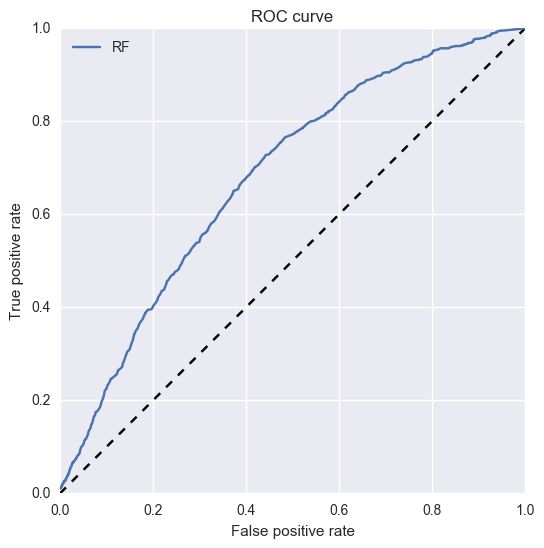

In [10]:
fpr, tpr, thresholds = roc_curve(y_val, pred_probs, pos_label=1)
plt.figure(figsize=(6, 6), dpi=200)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## XGBoost

In [11]:
dm_train = xgb.DMatrix(X_train, y_train)
dm_val = xgb.DMatrix(X_val, y_val)
watchlist = [(dm_val, 'val')]
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'eta': 0.05,
    'max_depth': 5,
    'silent': 0,
    'eval_metric': 'auc'
}

clf = xgb.train(params, dm_train, 500, watchlist, early_stopping_rounds=30)
y_pred_proba = clf.predict(dm_val, ntree_limit=clf.best_ntree_limit)
round(roc_auc_score(y_val, y_pred_proba), 5)

[0]	val-auc:0.692139
Will train until val-auc hasn't improved in 30 rounds.
[1]	val-auc:0.701226
[2]	val-auc:0.699635
[3]	val-auc:0.699892
[4]	val-auc:0.701136
[5]	val-auc:0.701311
[6]	val-auc:0.70258
[7]	val-auc:0.703062
[8]	val-auc:0.703585
[9]	val-auc:0.704407
[10]	val-auc:0.705206
[11]	val-auc:0.70477
[12]	val-auc:0.705359
[13]	val-auc:0.706088
[14]	val-auc:0.706607
[15]	val-auc:0.707146
[16]	val-auc:0.707738
[17]	val-auc:0.707694
[18]	val-auc:0.707082
[19]	val-auc:0.707243
[20]	val-auc:0.707415
[21]	val-auc:0.707404
[22]	val-auc:0.707601
[23]	val-auc:0.707377
[24]	val-auc:0.707552
[25]	val-auc:0.707756
[26]	val-auc:0.707963
[27]	val-auc:0.708355
[28]	val-auc:0.708469
[29]	val-auc:0.708634
[30]	val-auc:0.70821
[31]	val-auc:0.708279
[32]	val-auc:0.708232
[33]	val-auc:0.70799
[34]	val-auc:0.708213
[35]	val-auc:0.708458
[36]	val-auc:0.708595
[37]	val-auc:0.708585
[38]	val-auc:0.708774
[39]	val-auc:0.708875
[40]	val-auc:0.708789
[41]	val-auc:0.708886
[42]	val-auc:0.709471
[43]	val-auc:

0.71001999999999998

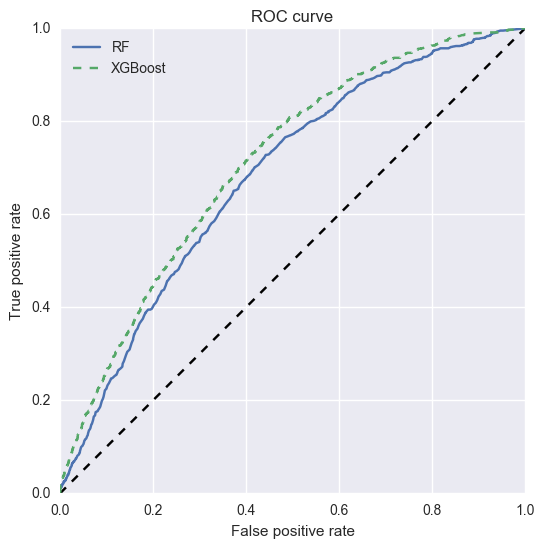

In [12]:
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_val, y_pred_proba, pos_label=1)
plt.figure(figsize=(6, 6), dpi=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.plot(fpr_xgb, tpr_xgb, '--',label='XGBoost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

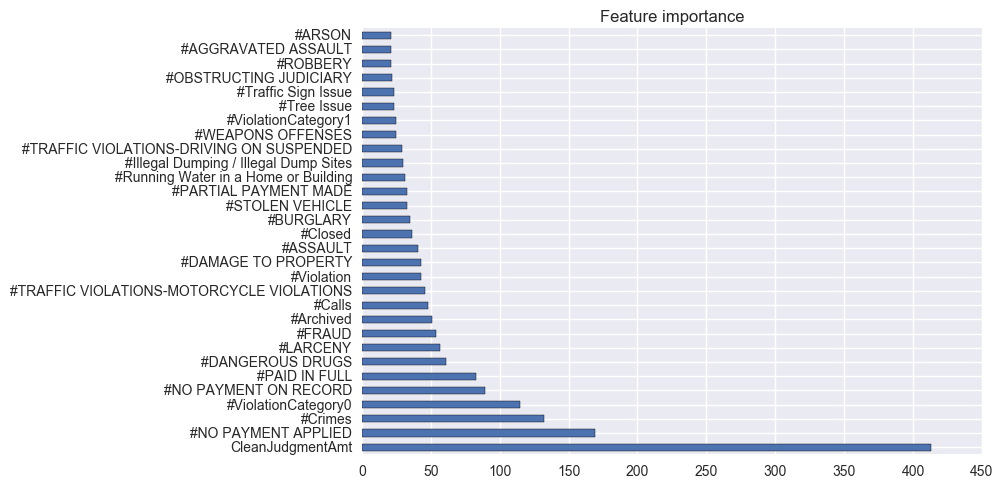

In [13]:
from xgboost.sklearn import XGBModel
from xgboost.core import Booster

importance_type='weight'
if isinstance(clf, XGBModel):
    importance = clf.booster().get_score(importance_type=importance_type)
elif isinstance(clf, Booster):
    importance = clf.get_score(importance_type=importance_type)
elif isinstance(clf, dict):
    importance = clf
    
feature_importance = pd.Series(importance, index=X_master.columns)
feature_importance.sort_values(inplace=True, ascending=False)
feature_importance.head(30).plot(kind='barh', title='Feature importance')

## Simplified XGBoost

In [14]:
X_master = train_df[['#Violation',
                     '#Crimes',
                     '#Calls',
                     '#ViolationCategory0',
                     '#ViolationCategory1',
                     'CleanJudgmentAmt',
                     #'#NO PAYMENT APPLIED',
                     #'#NO PAYMENT ON RECORD',
                     #'#PAID IN FULL',
                     #'#PARTIAL PAYMENT MADE',
                     #'#Archived',
                     #'#Closed',
                     #'#Acknowledged',
                     #'#Open',
                     'MeanCallRating']]

y_master = train_df['Blighted']

X_train, X_val, y_train, y_val = train_test_split(X_master, y_master, test_size=0.3, stratify = y_master)

In [15]:
dm_train = xgb.DMatrix(X_train, y_train)
dm_val = xgb.DMatrix(X_val, y_val)
watchlist = [(dm_val, 'val')]
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'eta': 0.05,
    'max_depth': 4,
    'silent': 0,
    'eval_metric': 'auc'
}

clf = xgb.train(params, dm_train, 500, watchlist, early_stopping_rounds=30)
y_pred_proba = clf.predict(dm_val, ntree_limit=clf.best_ntree_limit)
round(roc_auc_score(y_val, y_pred_proba), 5)

[0]	val-auc:0.687629
Will train until val-auc hasn't improved in 30 rounds.
[1]	val-auc:0.687227
[2]	val-auc:0.690356
[3]	val-auc:0.691147
[4]	val-auc:0.690976
[5]	val-auc:0.688506
[6]	val-auc:0.689179
[7]	val-auc:0.690362
[8]	val-auc:0.689902
[9]	val-auc:0.690638
[10]	val-auc:0.690404
[11]	val-auc:0.690223
[12]	val-auc:0.690711
[13]	val-auc:0.690925
[14]	val-auc:0.691431
[15]	val-auc:0.69182
[16]	val-auc:0.691072
[17]	val-auc:0.691195
[18]	val-auc:0.69078
[19]	val-auc:0.691063
[20]	val-auc:0.69123
[21]	val-auc:0.690885
[22]	val-auc:0.691036
[23]	val-auc:0.691177
[24]	val-auc:0.691022
[25]	val-auc:0.691044
[26]	val-auc:0.691155
[27]	val-auc:0.691257
[28]	val-auc:0.691499
[29]	val-auc:0.691474
[30]	val-auc:0.691408
[31]	val-auc:0.691433
[32]	val-auc:0.691407
[33]	val-auc:0.691268
[34]	val-auc:0.691297
[35]	val-auc:0.691226
[36]	val-auc:0.691193
[37]	val-auc:0.691295
[38]	val-auc:0.69125
[39]	val-auc:0.691317
[40]	val-auc:0.691439
[41]	val-auc:0.69148
[42]	val-auc:0.691432
[43]	val-auc:0

0.69181999999999999

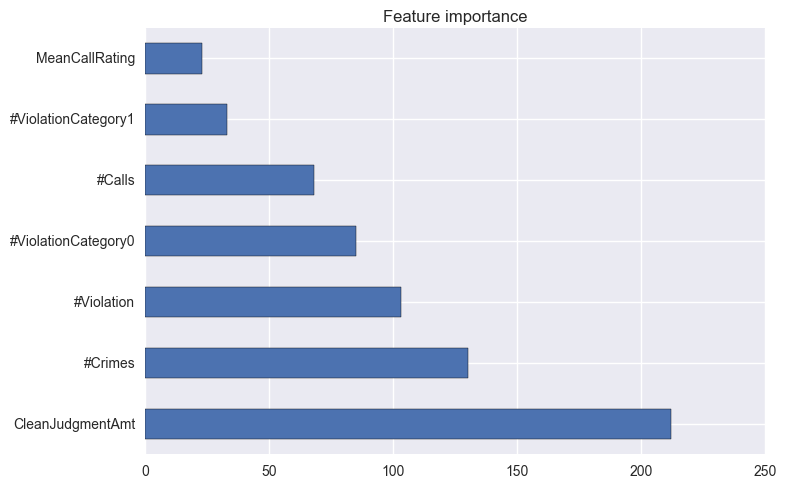

In [16]:
from xgboost.sklearn import XGBModel
from xgboost.core import Booster

importance_type='weight'
if isinstance(clf, XGBModel):
    importance = clf.booster().get_score(importance_type=importance_type)
elif isinstance(clf, Booster):
    importance = clf.get_score(importance_type=importance_type)
elif isinstance(clf, dict):
    importance = clf
    
feature_importance = pd.Series(importance, index=X_master.columns)
feature_importance.sort_values(inplace=True, ascending=False)
feature_importance.plot(kind='barh', title='Feature importance')

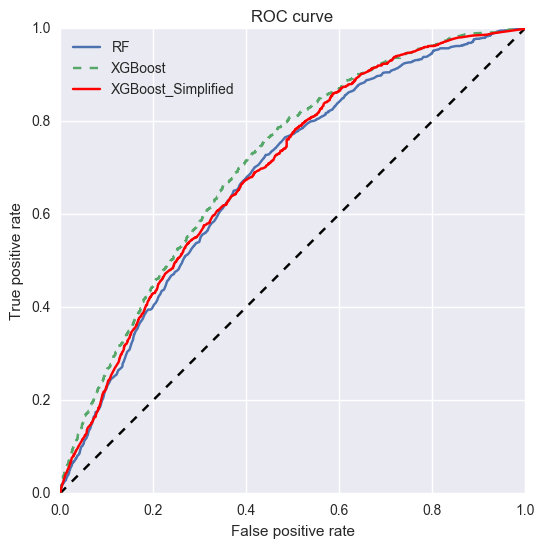

In [17]:
fpr_xgb_simplified, tpr_xgb_simplified, thresholds = roc_curve(y_val, y_pred_proba, pos_label=1)
plt.figure(figsize=(6, 6), dpi=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.plot(fpr_xgb, tpr_xgb, '--',label='XGBoost')
plt.plot(fpr_xgb_simplified, tpr_xgb_simplified, 'r',label='XGBoost_Simplified')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [18]:
clf.dump_model('dump.raw.txt')

In [19]:
clf.feature_names

['#Violation',
 '#Crimes',
 '#Calls',
 '#ViolationCategory0',
 '#ViolationCategory1',
 'CleanJudgmentAmt',
 'MeanCallRating']